In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os

## Read in single file output

In [2]:
# Uncomment to read in a single file
"""
ftype = 'h5'
base = 'output/'
cfg = 'cl3_16_48_b6p1_m0p2450_output1693'
file = base + cfg + '.' + ftype
L3 = 48    #temporal extent of lattice
C = []
if ftype == 'txt':
    f = open(file, 'r')
    # New read in format: Each line after the first of form cfgId|a1+ib a2+ib ...
    f.readline()
    for i, line in enumerate(f):
        # if i not in sample_ids:
        #     continue
        cur_line = np.zeros(L3, dtype=complex)
        cfgIdx, rest = line.split('|')
        cfgIdx = int(cfgIdx)
        interps = rest.split(' ')    # now get real and complex
        for n_t, x in enumerate(interps):
            if not x.isspace():
                real, imag = x.split('+i(')    #form should be x = a+i(b)
                real = float(real)
                imag = float(imag.replace(')', ''))
                cur_line[n_t] = complex(real, imag)
        cur_line = [cur_line]
        if C == []:
            C = np.array(cur_line)
        else:
            C = np.append(C, cur_line, axis = 0)
elif ftype == 'h5':
    f = h5py.File(file, 'r')
    correlators = f['twopt']
    for i, data in correlators.items():
        if C == []:
            C = np.array(data)
        else:
            C = np.vstack([C, data])
else:
    raise Exception("File type cannot be read in.")
"""

'\nftype = \'h5\'\nbase = \'output/\'\ncfg = \'cl3_16_48_b6p1_m0p2450_output1693\'\nfile = base + cfg + \'.\' + ftype\nL3 = 48    #temporal extent of lattice\nC = []\nif ftype == \'txt\':\n    f = open(file, \'r\')\n    # New read in format: Each line after the first of form cfgId|a1+ib a2+ib ...\n    f.readline()\n    for i, line in enumerate(f):\n        # if i not in sample_ids:\n        #     continue\n        cur_line = np.zeros(L3, dtype=complex)\n        cfgIdx, rest = line.split(\'|\')\n        cfgIdx = int(cfgIdx)\n        interps = rest.split(\' \')    # now get real and complex\n        for n_t, x in enumerate(interps):\n            if not x.isspace():\n                real, imag = x.split(\'+i(\')    #form should be x = a+i(b)\n                real = float(real)\n                imag = float(imag.replace(\')\', \'\'))\n                cur_line[n_t] = complex(real, imag)\n        cur_line = [cur_line]\n        if C == []:\n            C = np.array(cur_line)\n        else:\n 

## Read in single directory output

In [3]:
# Uncomment for single directory output
ftype = 'h5'
# cfgbase = 'su3_24_48_b6p10050'
cfgbase = 'cl3_16_48_b6p1_m0p2450'
job_num = 5741
base = './output/' + cfgbase + '_' + str(job_num)
save_graphs = False

files = []
for (dirpath, dirnames, file) in os.walk(base):
    files.extend(file)
C = []
for file in files:
    path_to_file = base + '/' + file
    f = h5py.File(path_to_file, 'r')
    correlators = f['twopt']
    for i, data in correlators.items():
        if len(C) == 0:
            C = np.array(data)
        else:
            C = np.vstack([C, data])

## Bootstrap data

In [4]:
def bootstrap(C, n_boot = 500):
    num_configs = C.shape[0]
    n_t = C.shape[1]
    samples = np.zeros((n_boot, num_configs, n_t), dtype = complex)
    for i in range(n_boot):
        cfgIds = np.random.choice(num_configs, num_configs)    #Configuration ids to pick
        samples[i, :, :] = C[cfgIds, :]
    return samples

In [5]:
num_configs = C.shape[0]
n_t = C.shape[1]
samples = bootstrap(C)
print(samples.shape)

(500, 253, 48)


## Compute correlation function and effective mass

In [6]:
# Compute ensemble average of each correlation function
ensemble_avg = np.mean(samples, axis = 1)
μ_C = np.abs(np.mean(ensemble_avg, axis = 0))
σ_C = np.abs(np.std(ensemble_avg, axis = 0))

In [7]:
# Compute effective mass
ratios = np.abs(ensemble_avg / np.roll(ensemble_avg, shift = -1, axis = 1))[:, :-1]
m_eff_ensemble = np.log(ratios)
μ_m_eff = np.mean(m_eff_ensemble, axis = 0)
σ_m_eff = np.std(m_eff_ensemble, axis = 0, ddof = 1)

In [8]:
# Compute cosh-corrected effective mass
N = 48
cosh_m_eff_ensemble = np.zeros(ratios.shape)
for ens_idx in range(ratios.shape[0]):
    for t in range(ratios.shape[1]):
        m = root(lambda m : ratios[ens_idx, t] - np.cosh(m * (t - N / 2)) / np.cosh(m * (t + 1 - N / 2)), \
                     m_eff_ensemble[ens_idx, t])
        cosh_m_eff_ensemble[ens_idx, t] = m.x
μ_cosh = np.mean(cosh_m_eff_ensemble, axis = 0)
σ_cosh = np.std(cosh_m_eff_ensemble, axis = 0, ddof = 1)

<IPython.core.display.Javascript object>


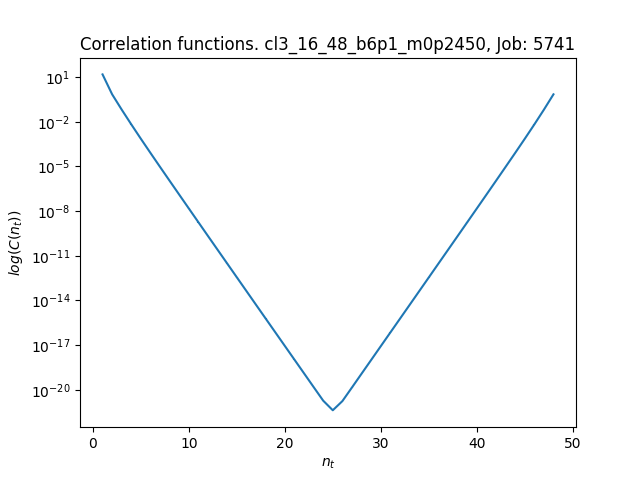

Text(0, 0.5, '$log(C(n_t))$')

In [9]:
plt.figure()
plt.errorbar(range(1, n_t + 1), μ_C, yerr = σ_C)
plt.yscale('log')
plt.title('Correlation functions. ' + cfgbase + ', Job: ' + str(job_num))
plt.xlabel('$n_t$')
plt.ylabel('$log(C(n_t))$')

In [10]:
if save_graphs:
    plt.savefig('/Users/theoares/lqcd/pion_mass/output/graphs/1_22_2020/' + cfgbase + '/twopt' + str(job_num) + '.png')

<IPython.core.display.Javascript object>


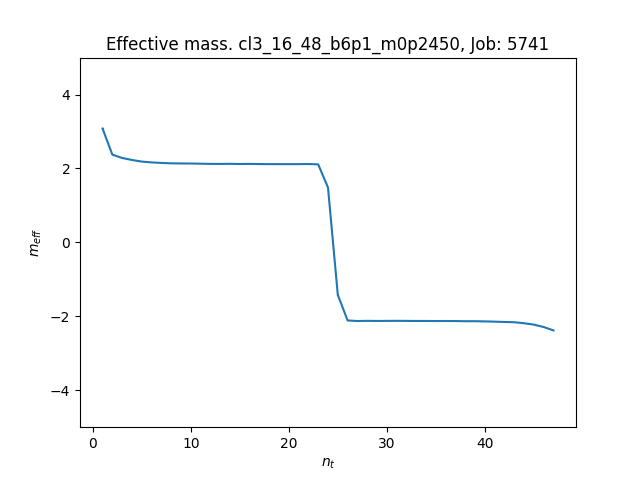

Text(0, 0.5, '$m_{eff}$')

In [11]:
plt.figure()
plt.errorbar(range(1, n_t), μ_m_eff, yerr = σ_m_eff)
plt.title('Effective mass. ' + cfgbase + ', Job: ' + str(job_num))
plt.ylim((-5, 5))
plt.xlabel('$n_t$')
plt.ylabel('$m_{eff}$')

In [12]:
if save_graphs:
    plt.savefig('/Users/theoares/lqcd/pion_mass/output/graphs/1_22_2020/' + cfgbase + '/meff_' + str(job_num) + '.png')

In [13]:
σ_m_eff

array([0.00186981, 0.00315162, 0.00404731, 0.00395166, 0.00411287,
       0.00373777, 0.0036796 , 0.00327953, 0.00327144, 0.00306285,
       0.00290572, 0.00292728, 0.00282681, 0.0026688 , 0.00234311,
       0.00229268, 0.00256998, 0.00256819, 0.00235552, 0.00228704,
       0.00224539, 0.00194015, 0.00189663, 0.01799219, 0.01949599,
       0.00209815, 0.00195256, 0.00205781, 0.00203752, 0.00224629,
       0.0022791 , 0.00236078, 0.00265614, 0.00256413, 0.00259723,
       0.00280733, 0.00266863, 0.0029911 , 0.00321544, 0.00315164,
       0.00313967, 0.00288765, 0.00357047, 0.00372905, 0.00381442,
       0.00384927, 0.00324938])

In [14]:
print(μ_m_eff[10])
print(σ_m_eff[10])

print(μ_m_eff[20])
print(σ_m_eff[20])

2.129738820227475
0.0029057181741720087
2.1178880772244915
0.002245385863837504


<IPython.core.display.Javascript object>


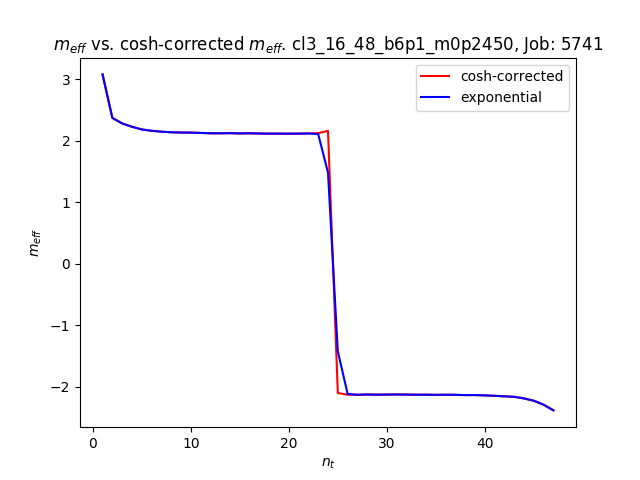

In [15]:
plt.figure()
plt.plot(range(1, n_t), μ_cosh, 'r', label = 'cosh-corrected')
plt.plot(range(1, n_t), μ_m_eff, 'b', label = 'exponential')

plt.title('$m_{eff}$ vs. cosh-corrected $m_{eff}$. ' + cfgbase + ', Job: ' + str(job_num))
# plt.ylim((-3, 3))
plt.xlabel('$n_t$')
plt.ylabel('$m_{eff}$')
plt.legend()

plt.show()

In [16]:
if save_graphs:
    plt.savefig('/Users/theoares/lqcd/pion_mass/output/graphs/1_22_2020/' + cfgbase + '/meff_cosh_' + str(job_num) + '.png')

## Determine effective mass

In [17]:
half = n_t // 2
flipped = np.concatenate([μ_cosh[:half], -μ_cosh[half:]])

In [18]:
# t_fit = [x for x in range(0, n_t - 1) if x != half - 1 and x != half]
t_fit = np.arange(15, 35)
m_eff = np.polyfit(t_fit, flipped[t_fit], 0)[0]
m_plot = np.ones(n_t - 1) * m_eff

<IPython.core.display.Javascript object>


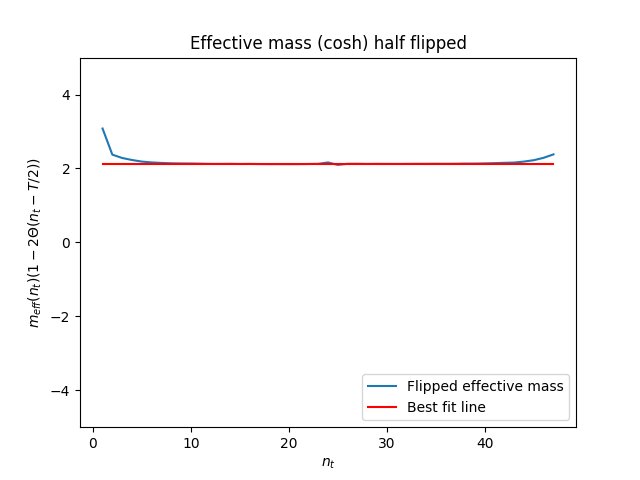

In [19]:
plt.figure()
plt.plot(range(1, n_t), flipped, label = 'Flipped effective mass')
plt.plot(range(1, n_t), m_plot, color = 'r', label = 'Best fit line')
plt.title('Effective mass (cosh) half flipped')
plt.ylim((-5, 5))
plt.xlabel('$n_t$')
plt.ylabel('$m_{eff}(n_t)(1 - 2Θ(n_t - T / 2))$')
plt.legend(loc = 'lower right')

In [20]:
print('Effective mass is: ' + str(m_eff))

Effective mass is: 2.12366831948728


## Determine error scaling

In [21]:
base_time = 15
cfg_list = range(10, num_configs, 10)
err = np.zeros(len(cfg_list))
means = np.zeros(len(cfg_list))
for i, n in enumerate(cfg_list):    # sample n configurations from C
    config_ids = np.random.choice(num_configs, n, replace = False)
    C_sub = C[config_ids, :]    #now get error on the subsampled C
    subensemble = bootstrap(C_sub)
    subensemble_avg = np.mean(subensemble, axis = 1)
    μ = np.abs(np.mean(subensemble_avg, axis = 0))
    σ = np.abs(np.std(subensemble_avg, axis = 0))
    err[i] = σ[base_time]
    means[i] = μ[base_time]

In [22]:
print('Errors are: ', err)
print('Average correlation function is: ', means)

Errors are:  [4.59687765e-15 2.11804159e-15 2.46255268e-15 2.92405546e-15
 2.16417362e-15 2.56544900e-15 2.15574760e-15 1.87176236e-15
 1.75207767e-15 1.42638499e-15 1.47090032e-15 1.61733748e-15
 1.39167293e-15 1.38933247e-15 1.34057578e-15 1.25545730e-15
 1.25373635e-15 1.20262211e-15 1.14604476e-15 1.28248392e-15
 1.04676910e-15 1.06746278e-15 1.04368303e-15 1.02099538e-15
 1.01947840e-15]
Average correlation function is:  [4.43927915e-14 4.12244837e-14 4.10967949e-14 4.83878473e-14
 4.48627069e-14 4.38069669e-14 4.43999145e-14 4.33808384e-14
 4.25865805e-14 4.18986778e-14 4.04500985e-14 4.29919031e-14
 4.16818479e-14 4.29738377e-14 4.13888775e-14 4.28118254e-14
 4.29003426e-14 4.36145018e-14 4.33023446e-14 4.30180690e-14
 4.26103441e-14 4.29151148e-14 4.27955996e-14 4.23562507e-14
 4.29679358e-14]


<IPython.core.display.Javascript object>


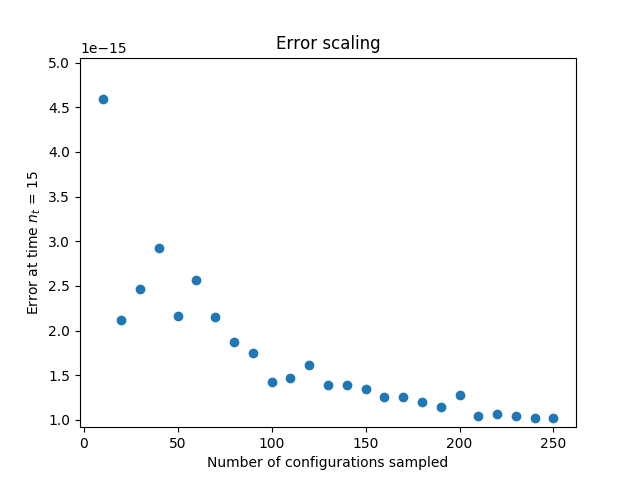

In [23]:
plt.figure()
plt.scatter(cfg_list, err)
plt.title('Error scaling')
plt.xlabel('Number of configurations sampled')
plt.ylabel('Error at time $n_t$ = ' + str(base_time))
# plt.ylim((1e-18, 1e-17))
plt.ylim((.9 * np.min(err), 1.1 * np.max(err)))
plt.show()